<a href="https://colab.research.google.com/github/t07902301/Reddit-Topics/blob/main/Spark_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites
Sign up to https://ngrok.com/ to be able to reach Spark UI

In [18]:
%%capture
!pip install pyspark
!pip install findspark
# !pip install pyngrok

In [19]:
# prompt: clean a string with spark by remove stopwords, punctuation, and perform tokenization

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import StopWordsRemover, Tokenizer
import json
from pyspark.sql.types import ArrayType, StringType

findspark.init()
spark = SparkSession.builder \
        .appName('testColab') \
        .getOrCreate()


In [69]:

# Read Subreddit JSON (assuming it's in the correct location)
with open('/content/travel.json', 'r') as file:
    data = json.load(file)

extracted_posts = [{'url': post['data']['url'], 'content': post['data']['title'] + ' ' + post['data']['selftext']} for post in data['data']['children']]

# Create a DataFrame
df = spark.createDataFrame(extracted_posts)

# 1. Convert to lowercase
df = df.withColumn("content", lower(col("content")))

# 2. Remove punctuation
df = df.withColumn("content", regexp_replace(col("content"), "[^a-zA-Z\\s]", ""))

# 3. Tokenize
tokenizer = Tokenizer(inputCol="content", outputCol="tokens")
df = tokenizer.transform(df)

# 4. Remove stop words
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df = remover.transform(df)

# Custom UDF to filter words by length
def filter_short_words(words):
    return [word for word in words if len(word) > 3]  # Keep words longer than 2 characters

filter_udf = udf(filter_short_words, ArrayType(StringType()))
df = df.withColumn("meaningful_wtokens", filter_udf(col("filtered_tokens")))

# Show the DataFrame with the cleaned text
df.select("url", "meaningful_wtokens").show(truncate=False)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [70]:
type(data)

dict

In [71]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import ArrayType, StringType
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets')
def extract_nouns(tokens):
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Extract nouns based on POS tags (NN, NNS, NNP, NNPS)
    nouns = [word for word, pos in tagged_tokens if pos.startswith('NN')]
    return nouns

# Create a UDF
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [72]:
df = df.withColumn("meaningful_wtokens", extract_nouns_udf(col("meaningful_wtokens")))

In [73]:
df.select("url", "meaningful_wtokens").show(truncate=False)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [74]:
# prompt: Count frequencies of filtered_tokens in a spark dataframe

from pyspark.sql.functions import explode, count

# Explode the filtered_tokens array into separate rows
exploded_df = df.select("url", explode("meaningful_wtokens").alias("token"))

# Group by token and count occurrences
token_counts = exploded_df.groupBy("token").agg(count("*").alias("frequency"))

# Show the token counts
token_counts.show()

+---------+---------+
|    token|frequency|
+---------+---------+
|   travel|       32|
|   online|        2|
|     hope|        2|
|     iffy|        1|
|  contiki|        1|
|    trail|        3|
|kathmandu|        1|
|  jewelry|        1|
|   waters|        1|
|    pools|        2|
|  barrier|        1|
|     tons|        1|
|guimaraes|        2|
|   sagres|        1|
|    parts|        2|
|   nights|       14|
|consulate|        1|
| hometown|        1|
| jardines|        1|
|    vibes|        1|
+---------+---------+
only showing top 20 rows



In [78]:
# prompt: remove tokens of travel and trips from token_counts

from pyspark.sql.functions import col

# Filter out rows where the token is "travel" or "trips"
filtered_token_counts = token_counts.filter(~col("token").isin("travel", "trips", "travels", "trip"))

# Show the filtered token counts
filtered_token_counts.show()

+---------+---------+
|    token|frequency|
+---------+---------+
|   online|        2|
|     hope|        2|
|     iffy|        1|
|  contiki|        1|
|    trail|        3|
|kathmandu|        1|
|  jewelry|        1|
|   waters|        1|
|    pools|        2|
|  barrier|        1|
|     tons|        1|
|guimaraes|        2|
|   sagres|        1|
|    parts|        2|
|   nights|       14|
|consulate|        1|
| hometown|        1|
| jardines|        1|
|    vibes|        1|
|  rockies|        1|
+---------+---------+
only showing top 20 rows



In [75]:

# # Collect URLs for each token
# def collect_urls_for_token(token_and_url):
#   token = token_and_url[0]
#   url = token_and_url[1]
#   return (token, url)
# url_per_token = df.select(explode("meaningful_wtokens"), "url").rdd.map(collect_urls_for_token).groupByKey().mapValues(list).collect()


# for token, urls in url_per_token:
#     print(f"Token: {token}, URLs: {urls}")

In [76]:
exploded_df.show(2)

+--------------------+--------------------+
|                 url|               token|
+--------------------+--------------------+
|https://www.reddi...|           questions|
|https://www.reddi...|httpswwwredditcom...|
+--------------------+--------------------+
only showing top 2 rows



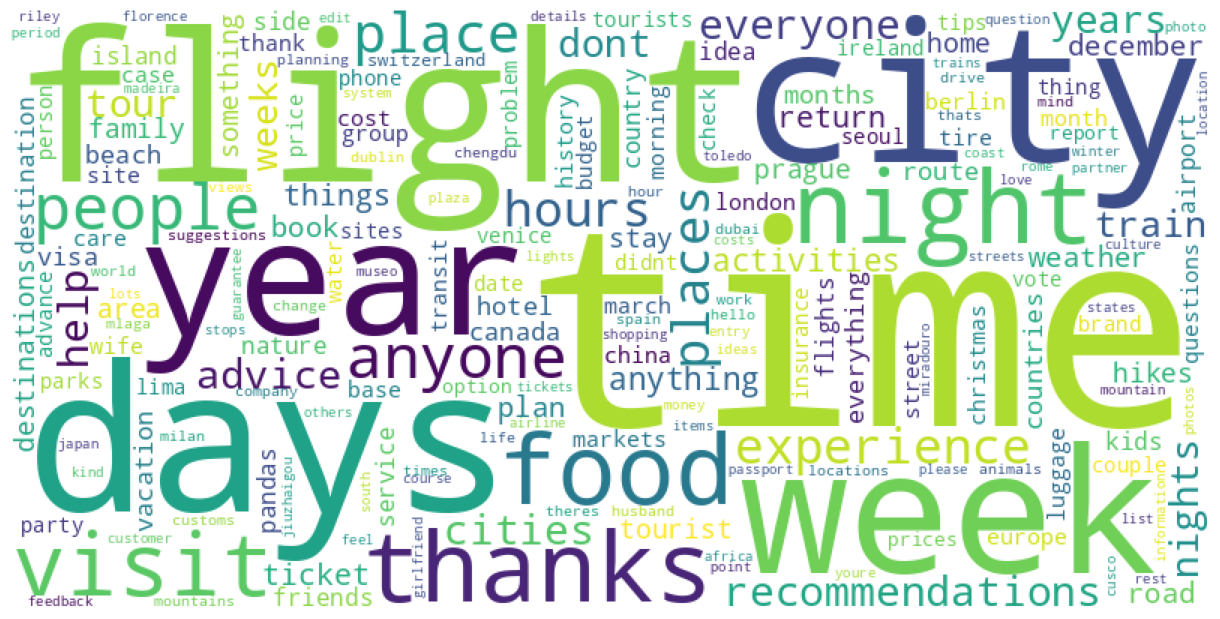

In [79]:
# prompt: create a word cloud based on counted word frequencies

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'word_counts' is your DataFrame with 'word' and 'count' columns as shown in the previous code snippet.
# If 'word_counts' is not available, execute the previous code before this cell.

# Convert the Spark DataFrame to a Pandas DataFrame
word_counts_pandas = filtered_token_counts.toPandas()

# Create a dictionary of word frequencies
word_freq = dict(zip(word_counts_pandas['token'], word_counts_pandas['frequency']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the generated image:
plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()